In [1]:
# Importing essential libraries

# Data Gathering 
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#data spliting
from sklearn.model_selection import train_test_split

#column transformer
from sklearn.compose import ColumnTransformer

#Encoding
from sklearn.preprocessing import OneHotEncoder

#pipeline
from sklearn.pipeline import Pipeline

#Model Selection
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgboost
from sklearn.ensemble import RandomForestClassifier

# metric evaluation
from sklearn.metrics import accuracy_score,r2_score,recall_score,precision_score,confusion_matrix,roc_auc_score

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Data Gathering 

In [3]:
deliveries = pd.read_csv('deliveries.csv')
deliveries.sample(7)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
101188,733985,2,Kolkata Knight Riders,Delhi Daredevils,12,2,G Gambhir,S Nadeem,MK Pandey,2,0,2,NaN,0,NaN,NaN,NaN
171618,1178404,1,Kolkata Knight Riders,Chennai Super Kings,12,4,KD Karthik,MJ Santner,CA Lynn,0,0,0,NaN,0,NaN,NaN,NaN
85934,598037,2,Kings XI Punjab,Mumbai Indians,0,3,Mandeep Singh,MG Johnson,SE Marsh,0,0,0,NaN,0,NaN,NaN,NaN
192741,1237177,1,Mumbai Indians,Delhi Capitals,17,1,HH Pandya,DR Sams,Ishan Kishan,6,0,6,NaN,0,NaN,NaN,NaN
168491,1175371,1,Delhi Capitals,Sunrisers Hyderabad,10,4,R Tewatia,Sandeep Sharma,SS Iyer,0,0,0,NaN,0,NaN,NaN,NaN
202472,1254095,1,Sunrisers Hyderabad,Royal Challengers Bangalore,3,2,JJ Roy,Shahbaz Ahmed,KS Williamson,1,0,1,NaN,0,NaN,NaN,NaN
200830,1254087,2,Kolkata Knight Riders,Royal Challengers Bangalore,7,2,Shubman Gill,PWH de Silva,VR Iyer,6,0,6,NaN,0,NaN,NaN,NaN


`Column` | Description
:-|:-
`match_id` |	Unique identifier for each match, used to link with match details.
`inning`|	Indicates the innings (1 or 2) in the match.
`batting_team`|Name of the team batting in the given inning.
`bowling_team`|	Name of the team bowling in the given inning.
`over`|	The over number in the current inning (e.g., 1, 2, ..., 20).
`ball`|	The ball number within the over (1 to 6).
`batter`|	Name of the player currently batting.
`bowler`	|Name of the player currently bowling.
`non_striker`|	Name of the non-striker at the other end of the pitch.
`batsman_runs`|	Number of runs scored by the batsman on the current delivery (can include 0 for dot balls or 4/6 for boundaries).
`extra_runs`	|Number of extra runs (such as no-balls, wides) on this delivery.
`total_runs`	|Total runs scored on this ball (sum of batsman runs and extra runs).
`extras_type`	|Type of extra run, if applicable (e.g., wide, no-ball, bye, legbye).
`is_wicket`	|Indicates if the delivery resulted in a wicket (1 for wicket, 0 for no wicket).
`player_dismissed`|	Name of the player dismissed on the ball (if applicable, otherwise null).
`dismissal_kind`	|Type of dismissal (e.g., bowled, caught, run out, LBW).
`fielder`	|Name of the fielder involved in the dismissal (for dismissals like catch, run out, etc.; null for dismissals not involving a fielder).

In [5]:
matches = pd.read_csv('matches.csv')
matches.sample(7)

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
580,1082594,2017,Indore,2017-04-08,League,GJ Maxwell,Holkar Cricket Stadium,Kings XI Punjab,Rising Pune Supergiant,Kings XI Punjab,field,Kings XI Punjab,wickets,6.0,164.0,20.0,N,NaN,AK Chaudhary,C Shamshuddin
918,1304089,2022,Mumbai,2022-04-30,League,R Tewatia,"Brabourne Stadium, Mumbai",Royal Challengers Bangalore,Gujarat Titans,Royal Challengers Bangalore,bat,Gujarat Titans,wickets,6.0,171.0,20.0,N,NaN,HAS Khalid,VK Sharma
554,980975,2016,Kolkata,2016-05-08,League,P Kumar,Eden Gardens,Kolkata Knight Riders,Gujarat Lions,Gujarat Lions,field,Gujarat Lions,wickets,5.0,159.0,20.0,N,NaN,M Erasmus,RJ Tucker
1006,1359531,2023,Mumbai,2023-05-12,League,SA Yadav,"Wankhede Stadium, Mumbai",Mumbai Indians,Gujarat Titans,Gujarat Titans,field,Mumbai Indians,runs,27.0,219.0,20.0,N,NaN,Nitin Menon,Tapan Sharma
269,548328,2012,Chandigarh,2012-04-18,League,G Gambhir,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,bat,Kolkata Knight Riders,wickets,8.0,125.0,20.0,N,NaN,JD Cloete,RJ Tucker
416,729315,2014,Abu Dhabi,2014-04-29,League,JP Faulkner,Sheikh Zayed Stadium,Kolkata Knight Riders,Rajasthan Royals,Rajasthan Royals,bat,Rajasthan Royals,tie,NaN,153.0,20.0,Y,NaN,Aleem Dar,AK Chaudhary
848,1254105,2021,Dubai,2021-09-22,League,A Nortje,Dubai International Cricket Stadium,Sunrisers Hyderabad,Delhi Capitals,Sunrisers Hyderabad,bat,Delhi Capitals,wickets,8.0,135.0,20.0,N,NaN,KN Ananthapadmanabhan,RK Illingworth


`Column`	|Description
:-|:-
`id`	|Unique identifier for each match, similar to match_id in the ball-by-ball dataset, useful for linking datasets.
`season`|	Year in which the IPL season took place.
`city`	|City where the match was played.
`date`	|Date of the match.
`match_type`|	Type of match (could indicate regular season, playoff, or final).
`player_of_match`|	Name of the player awarded "Player of the Match."
`venue`|	Stadium where the match was played.
`team1`	|Name of the first team (order doesn’t imply batting or bowling first).
`team2`	|Name of the second team.
`toss_winner`|	Team that won the toss.
`toss_decision`|	Decision taken by the toss-winning team (bat or field).
`winner`|Name of the team that won the match.
`result`|	Outcome type of the match (e.g., normal, tie, no result).
`result_margin`|	Margin by which the team won (e.g., runs or wickets).
`target_runs`	|Target runs set for the chasing team (null if not applicable).
`target_overs`	|Target overs if the match is shortened (e.g., in rain-affected matches; null if not applicable).
`super_over`	|Indicates if the match had a super over (1 for yes, 0 for no).
`method`	|Method used to determine the result in rain-affected games (e.g., Duckworth-Lewis-Stern, or null if not applicable).
`umpire1`	|Name of the first on-field umpire.
`umpire2`	|Name of the second on-field umpire.

- here we have two datasets one containing ball by ball details and other containing match wise details.
- we are going to analyse each data set for insights.


#### Data Cleaning

In [9]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          260920 non-null  int64 
 1   inning            260920 non-null  int64 
 2   batting_team      260920 non-null  object
 3   bowling_team      260920 non-null  object
 4   over              260920 non-null  int64 
 5   ball              260920 non-null  int64 
 6   batter            260920 non-null  object
 7   bowler            260920 non-null  object
 8   non_striker       260920 non-null  object
 9   batsman_runs      260920 non-null  int64 
 10  extra_runs        260920 non-null  int64 
 11  total_runs        260920 non-null  int64 
 12  extras_type       14125 non-null   object
 13  is_wicket         260920 non-null  int64 
 14  player_dismissed  12950 non-null   object
 15  dismissal_kind    12950 non-null   object
 16  fielder           9354 non-null    obj

- here we get data information where we know basics about our data
    - There are 260920 rows and 17 columns in deliveries dataset.
    - some columns have missing values.


In [11]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_overs     1092 non-null   float64
 16  super_over       1095 non-null   object 
 17  method        

- Here  we have 1095 rows and 20 columns .
- there are some missing values in this data.
- Date column is in form of object which can be converted into date time for better analysis.

##### Further I cleaned both datas column wise 

#### Deliveries cleaning 

In [15]:
deliveries.sample(25)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
251029,1426268,1,Sunrisers Hyderabad,Royal Challengers Bengaluru,19,3,AK Markram,Vijaykumar Vyshak,Abdul Samad,6,0,6,NaN,0,NaN,NaN,NaN
148247,1082641,1,Kings XI Punjab,Mumbai Indians,8,3,GJ Maxwell,Harbhajan Singh,WP Saha,1,0,1,NaN,0,NaN,NaN,NaN
167391,1175366,2,Royal Challengers Bangalore,Sunrisers Hyderabad,13,2,C de Grandhomme,Rashid Khan,P Ray Barman,4,0,4,NaN,0,NaN,NaN,NaN
6307,336008,2,Mumbai Indians,Rajasthan Royals,6,4,YV Takawale,Sohail Tanvir,ST Jayasuriya,1,0,1,NaN,0,NaN,NaN,NaN
209721,1304053,2,Lucknow Super Giants,Chennai Super Kings,14,2,E Lewis,D Pretorius,Q de Kock,0,0,0,NaN,0,NaN,NaN,NaN
135715,981013,1,Gujarat Lions,Royal Challengers Bangalore,15,2,RA Jadeja,SR Watson,DR Smith,0,0,0,NaN,0,NaN,NaN,NaN
37144,419147,1,Chennai Super Kings,Deccan Chargers,11,3,MS Dhoni,PP Ojha,SK Raina,0,0,0,NaN,0,NaN,NaN,NaN
113016,829739,1,Delhi Daredevils,Kolkata Knight Riders,0,5,MA Agarwal,UT Yadav,SS Iyer,0,1,1,wides,0,NaN,NaN,NaN
183313,1216509,2,Delhi Capitals,Chennai Super Kings,2,5,S Dhawan,DL Chahar,AM Rahane,4,0,4,NaN,0,NaN,NaN,NaN
145663,1082630,1,Sunrisers Hyderabad,Delhi Daredevils,11,2,KS Williamson,Mohammed Shami,Yuvraj Singh,1,0,1,NaN,0,NaN,NaN,NaN


#### match_id

In [17]:
deliveries['match_id'].isnull().sum()

0

In [18]:
deliveries['match_id'].nunique()

1095

- In match_id column there isn't any null value .
- Their are 1095 unique match id's which matches #rows in matches dataset.
   i.e. We have information of all matches.

#### inning

In [21]:
deliveries['inning'].isnull().sum()

0

In [22]:
deliveries['inning'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

- here data does not have null values.
- but innings values are little disturbed, as we know their should be only 2 innings but have till 6.
    - 3rd and 4th inning is their due to a super over but 5th and 6th inning is a entry error.

In [24]:
# If inning are 5 changing to 3 and if 6 changed to 4
def inning_replacing(inning):
    if inning == 5:
        return 3
    elif inning == 6:
        return 4
    else:
        return inning

In [25]:
deliveries['inning']=deliveries['inning'].apply(inning_replacing)

In [26]:
deliveries['inning'].unique()

array([1, 2, 3, 4], dtype=int64)

#### batting team

In [28]:
deliveries['batting_team'].isnull().sum()

0

In [29]:
deliveries['batting_team'].nunique()

19

In [30]:
deliveries['batting_team'].unique()

array(['Kolkata Knight Riders', 'Royal Challengers Bangalore',
       'Chennai Super Kings', 'Kings XI Punjab', 'Rajasthan Royals',
       'Delhi Daredevils', 'Mumbai Indians', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

- their is no null value in batting team
- over the years names of teams are changed so same team is present with several names or their are some speeling difference

In [32]:
# correcting teams name if differs
def change_team_name(team_name):
    if team_name in ['Rising Pune Supergiants','Pune Warriors']:
        return 'Rising Pune Supergiant'
    elif team_name == 'Royal Challengers Bengaluru':
        return 'Royal Challengers Bangalore'
    elif team_name == 'Deccan Chargers':
        return 'Sunrisers Hyderabad'
    elif team_name == 'Delhi Daredevils':
        return 'Delhi Capitals'
    elif team_name == 'Gujarat Lions':
        return 'Gujarat Titans'
    elif team_name == 'Kings XI Punjab':
        return 'Punjab Kings'
    else:
        return team_name

In [33]:
deliveries['batting_team'] = deliveries['batting_team'].apply(change_team_name)

In [34]:
deliveries['batting_team'].nunique()

12

- there were 19 teams in batting team column which reduced to 12 as we know till today 12 teams were played in IPL

#### bowling team

In [37]:
deliveries['bowling_team'].isnull().sum()

0

In [38]:
deliveries['bowling_team'].nunique()

19

In [39]:
deliveries['bowling_team'] = deliveries['bowling_team'].apply(change_team_name)

In [40]:
deliveries['bowling_team'].nunique()

12

- their were 19 teams reduced to 12 with same problem as batting team

#### Over

In [43]:
deliveries['over'].isnull().sum()

0

In [44]:
deliveries['over'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

- 20 overs are present 1 over is calculated after completing.

#### ball

In [47]:
deliveries['ball'].isnull().sum()

0

In [48]:
deliveries['ball'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

- as we know each over has 6 balls their can be wides and no balls in some overs.

#### batter

In [51]:
deliveries['batter'].isnull().sum()

0

In [52]:
deliveries['batter'].nunique()

673

In [53]:
deliveries['batter'].unique()

array(['SC Ganguly', 'BB McCullum', 'RT Ponting', 'DJ Hussey',
       'Mohammad Hafeez', 'R Dravid', 'W Jaffer', 'V Kohli', 'JH Kallis',
       'CL White', 'MV Boucher', 'B Akhil', 'AA Noffke', 'P Kumar',
       'Z Khan', 'SB Joshi', 'PA Patel', 'ML Hayden', 'MEK Hussey',
       'MS Dhoni', 'SK Raina', 'JDP Oram', 'S Badrinath', 'K Goel',
       'JR Hopes', 'KC Sangakkara', 'Yuvraj Singh', 'SM Katich',
       'IK Pathan', 'T Kohli', 'YK Pathan', 'SR Watson', 'M Kaif',
       'DS Lehmann', 'RA Jadeja', 'M Rawat', 'D Salunkhe', 'SK Warne',
       'SK Trivedi', 'G Gambhir', 'V Sehwag', 'S Dhawan', 'L Ronchi',
       'ST Jayasuriya', 'DJ Thornely', 'RV Uthappa', 'PR Shah',
       'AM Nayar', 'SM Pollock', 'Harbhajan Singh', 'S Chanderpaul',
       'LRPL Taylor', 'AC Gilchrist', 'Y Venugopal Rao', 'VVS Laxman',
       'A Symonds', 'RG Sharma', 'SB Styris', 'AS Yadav', 'SB Bangar',
       'WPUJC Vaas', 'RP Singh', 'WP Saha', 'LR Shukla',
       'DPMD Jayawardene', 'S Sohal', 'B Lee', 'PP Cha

- there are total 673 batter played in IPL till now

#### bowler

In [56]:
deliveries['bowler'].isnull().sum()

0

In [57]:
deliveries['bowler'].nunique()

530

In [58]:
deliveries['bowler'].unique()

array(['P Kumar', 'Z Khan', 'AA Noffke', 'JH Kallis', 'SB Joshi',
       'CL White', 'AB Dinda', 'I Sharma', 'AB Agarkar', 'SC Ganguly',
       'LR Shukla', 'B Lee', 'S Sreesanth', 'JR Hopes', 'IK Pathan',
       'K Goel', 'PP Chawla', 'WA Mota', 'JDP Oram', 'MS Gony',
       'M Muralitharan', 'P Amarnath', 'Joginder Sharma', 'GD McGrath',
       'B Geeves', 'MF Maharoof', 'R Bhatia', 'DL Vettori', 'MM Patel',
       'SR Watson', 'SK Trivedi', 'SK Warne', 'YK Pathan', 'D Salunkhe',
       'R Vinay Kumar', 'B Akhil', 'A Nehra', 'SM Pollock', 'DS Kulkarni',
       'ST Jayasuriya', 'Harbhajan Singh', 'AM Nayar', 'M Kartik',
       'Mohammad Hafeez', 'DJ Hussey', 'WPUJC Vaas', 'RP Singh',
       'SB Styris', 'SB Bangar', 'A Symonds', 'PP Ojha', 'Pankaj Singh',
       'Mohammad Asif', 'VY Mahesh', 'Shahid Afridi', 'DJ Bravo',
       'VS Yeligati', 'MA Khote', 'D Kalyankrishna', 'VRV Singh',
       'Sohail Tanvir', 'A Kumble', 'DNT Zoysa', 'SD Chitnis',
       'Yuvraj Singh', 'Shoaib Malik',

- 530 bowlers played IPL till now

#### non-striker

In [61]:
deliveries['non_striker'].isnull().sum()

0

In [62]:
deliveries['non_striker'].nunique()

663

In [63]:
deliveries['non_striker'].unique()

array(['BB McCullum', 'SC Ganguly', 'RT Ponting', 'DJ Hussey',
       'Mohammad Hafeez', 'W Jaffer', 'R Dravid', 'V Kohli', 'JH Kallis',
       'CL White', 'MV Boucher', 'B Akhil', 'AA Noffke', 'P Kumar',
       'Z Khan', 'SB Joshi', 'ML Hayden', 'PA Patel', 'MEK Hussey',
       'MS Dhoni', 'SK Raina', 'JDP Oram', 'S Badrinath', 'JR Hopes',
       'K Goel', 'KC Sangakkara', 'Yuvraj Singh', 'SM Katich',
       'IK Pathan', 'YK Pathan', 'T Kohli', 'SR Watson', 'M Kaif',
       'DS Lehmann', 'RA Jadeja', 'M Rawat', 'D Salunkhe', 'SK Warne',
       'SK Trivedi', 'V Sehwag', 'G Gambhir', 'S Dhawan', 'ST Jayasuriya',
       'L Ronchi', 'DJ Thornely', 'RV Uthappa', 'PR Shah', 'AM Nayar',
       'SM Pollock', 'Harbhajan Singh', 'S Chanderpaul', 'LRPL Taylor',
       'Y Venugopal Rao', 'AC Gilchrist', 'VVS Laxman', 'A Symonds',
       'SB Styris', 'AS Yadav', 'SB Bangar', 'WPUJC Vaas', 'RP Singh',
       'PP Ojha', 'WP Saha', 'LR Shukla', 'DPMD Jayawardene', 'S Sohal',
       'PP Chawla', 'WA M

- there are total 663 unique values in non-striker

#### batsmam_runs

In [66]:
deliveries['batsman_runs'].isnull().sum()

0

In [67]:
deliveries['batsman_runs'].unique()

array([0, 4, 6, 1, 2, 5, 3], dtype=int64)

- values are till 6 that a batter can strike

#### extra_runs

In [70]:
deliveries['extra_runs'].isnull().sum()

0

In [71]:
deliveries['extra_runs'].unique()

array([1, 0, 5, 4, 2, 3, 7], dtype=int64)

- because of bowlers mistake some penalties are gives so the value is 7

#### Total_runs

In [74]:
deliveries['total_runs'].isnull().sum()

0

In [75]:
deliveries['total_runs'].unique()

array([1, 0, 4, 6, 5, 2, 3, 7], dtype=int64)

- there is no anamolous behaviour in this column

#### extras_type

In [78]:
deliveries['extras_type'].isnull().sum()

246795

In [79]:
deliveries['extras_type'].unique()

array(['legbyes', nan, 'wides', 'byes', 'noballs', 'penalty'],
      dtype=object)

- here we have 246795 null values which is valid as their isnt any extra runs for these ball.
- there is no need to fill these null values 
- we can futher drop this column as it is of no use.

#### is_wicket

In [82]:
deliveries['is_wicket'].isnull().sum()

0

In [83]:
deliveries['is_wicket'].unique()

array([0, 1], dtype=int64)

- in this column 0 means no wicket and 1 mean they caught a wicket.


#### player_dismissed

In [86]:
deliveries['player_dismissed'].isnull().sum()

247970

In [87]:
deliveries['player_dismissed'].unique()

array([nan, 'SC Ganguly', 'RT Ponting', 'DJ Hussey', 'R Dravid',
       'V Kohli', 'JH Kallis', 'W Jaffer', 'MV Boucher', 'B Akhil',
       'CL White', 'AA Noffke', 'Z Khan', 'SB Joshi', 'PA Patel',
       'ML Hayden', 'MS Dhoni', 'SK Raina', 'JDP Oram', 'K Goel',
       'JR Hopes', 'Yuvraj Singh', 'KC Sangakkara', 'T Kohli',
       'YK Pathan', 'SR Watson', 'DS Lehmann', 'M Kaif', 'M Rawat',
       'RA Jadeja', 'SK Warne', 'V Sehwag', 'L Ronchi', 'DJ Thornely',
       'ST Jayasuriya', 'PR Shah', 'RV Uthappa', 'AM Nayar', 'SM Pollock',
       'S Chanderpaul', 'LRPL Taylor', 'Y Venugopal Rao', 'VVS Laxman',
       'AC Gilchrist', 'RG Sharma', 'SB Styris', 'AS Yadav', 'A Symonds',
       'WPUJC Vaas', 'SB Bangar', 'PP Ojha', 'BB McCullum', 'WP Saha',
       'Mohammad Hafeez', 'DPMD Jayawardene', 'IK Pathan', 'B Lee',
       'S Sohal', 'Kamran Akmal', 'Shahid Afridi', 'G Gambhir',
       'MEK Hussey', 'DJ Bravo', 'MA Khote', 'Harbhajan Singh',
       'GC Smith', 'D Salunkhe', 'RR Sarwan',

- in this column we have the player of whose the wicket is caught
- the data is of every ball so their are many null value which is valid. 
- the column does not gives any specific value so we might delete it later.

#### dismissal_kind

In [90]:
deliveries['dismissal_kind'].isnull().sum()

247970

In [91]:
deliveries['dismissal_kind'].unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

- here also null values are valid due to same reason

#### fielder

In [94]:
deliveries['fielder'].isnull().sum()

251566

In [95]:
deliveries['fielder'].unique()

array([nan, 'JH Kallis', 'P Kumar', 'CL White', 'M Kartik', 'RT Ponting',
       'WP Saha', 'AB Agarkar', 'BB McCullum', 'KC Sangakkara',
       'IK Pathan', 'PA Patel', 'Joginder Sharma', 'P Amarnath',
       'M Manhas', 'B Geeves', 'V Kohli', 'Z Khan', 'MV Boucher',
       'AM Nayar', 'L Ronchi', 'LR Shukla', 'Mohammad Hafeez', 'AB Dinda',
       'DJ Hussey', 'SC Ganguly', 'RG Sharma', 'SB Styris', 'A Symonds',
       'Kamran Akmal', 'RA Jadeja', 'PP Chawla', 'S Dhawan', 'KD Karthik',
       'MK Tiwary', 'GD McGrath', 'G Gambhir', 'AC Gilchrist', 'DJ Bravo',
       'Harbhajan Singh', 'S Badrinath', 'JDP Oram', 'SK Raina',
       'D Salunkhe', 'SB Bangar', 'D Kalyankrishna', 'VVS Laxman',
       'DS Kulkarni', 'AM Rahane', 'A Nehra', 'B Lee', 'RR Sarwan',
       'Yuvraj Singh', 'MM Patel', 'GC Smith', 'M Rawat', 'Sohail Tanvir',
       'A Kumble', 'M Muralitharan', 'MS Dhoni', 'I Sharma', 'PP Ojha',
       'DPMD Jayawardene', 'V Sehwag', 'W Jaffer', 'R Vinay Kumar',
       'R Dravid',

- fielders who caused the dismissal of the player
- therefore null values are valid.

#### checking duplicate rows

In [98]:
deliveries[deliveries.duplicated()]

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder


- their isn't any duplicate value in our data

#### cleaning matches dataset

In [101]:
matches['id'].isnull().sum()

0

In [102]:
matches['id'].nunique()

1095

In [103]:
matches.rename(columns={'id':'match_id'},inplace=True)

- for our convinience column name is changed into match_id 

#### season

In [106]:
matches['season'].isnull().sum()

0

In [107]:
matches['season'].unique()

array(['2007/08', '2009', '2009/10', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020/21', '2021', '2022',
       '2023', '2024'], dtype=object)

In [108]:
matches[matches['season']=='2020/21']

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
756,1216492,2020/21,Abu Dhabi,2020-09-19,League,AT Rayudu,Sheikh Zayed Stadium,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,field,Chennai Super Kings,wickets,5.0,163.0,20.0,N,NaN,CB Gaffaney,VK Sharma
757,1216493,2020/21,NaN,2020-09-20,League,MP Stoinis,Dubai International Cricket Stadium,Delhi Capitals,Kings XI Punjab,Kings XI Punjab,field,Delhi Capitals,tie,NaN,158.0,20.0,Y,NaN,AK Chaudhary,Nitin Menon
758,1216534,2020/21,NaN,2020-09-21,League,YS Chahal,Dubai International Cricket Stadium,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,Royal Challengers Bangalore,runs,10.0,164.0,20.0,N,NaN,AY Dandekar,Nitin Menon
759,1216496,2020/21,NaN,2020-09-22,League,SV Samson,Sharjah Cricket Stadium,Rajasthan Royals,Chennai Super Kings,Chennai Super Kings,field,Rajasthan Royals,runs,16.0,217.0,20.0,N,NaN,C Shamshuddin,VA Kulkarni
760,1216508,2020/21,Abu Dhabi,2020-09-23,League,RG Sharma,Sheikh Zayed Stadium,Mumbai Indians,Kolkata Knight Riders,Kolkata Knight Riders,field,Mumbai Indians,runs,49.0,196.0,20.0,N,NaN,CB Gaffaney,S Ravi
761,1216510,2020/21,NaN,2020-09-24,League,KL Rahul,Dubai International Cricket Stadium,Kings XI Punjab,Royal Challengers Bangalore,Royal Challengers Bangalore,field,Kings XI Punjab,runs,97.0,207.0,20.0,N,NaN,AK Chaudhary,PR Reiffel
762,1216539,2020/21,NaN,2020-09-25,League,PP Shaw,Dubai International Cricket Stadium,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,Delhi Capitals,runs,44.0,176.0,20.0,N,NaN,KN Ananthapadmanabhan,RK Illingworth
763,1216545,2020/21,Abu Dhabi,2020-09-26,League,Shubman Gill,Sheikh Zayed Stadium,Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,Kolkata Knight Riders,wickets,7.0,143.0,20.0,N,NaN,CB Gaffaney,VK Sharma
764,1216527,2020/21,NaN,2020-09-27,League,SV Samson,Sharjah Cricket Stadium,Kings XI Punjab,Rajasthan Royals,Rajasthan Royals,field,Rajasthan Royals,wickets,4.0,224.0,20.0,N,NaN,RK Illingworth,K Srinivasan
765,1216547,2020/21,NaN,2020-09-28,League,AB de Villiers,Dubai International Cricket Stadium,Royal Challengers Bangalore,Mumbai Indians,Mumbai Indians,field,Royal Challengers Bangalore,tie,NaN,202.0,20.0,Y,NaN,Nitin Menon,PR Reiffel


- this column has some seasons in 2 year form. we have to convert this to single season 
- may be we can do this using date column. 

#### date

In [111]:
matches['date'].isnull().sum()

0

In [112]:
matches['date']

0       2008-04-18
1       2008-04-19
2       2008-04-19
3       2008-04-20
4       2008-04-20
           ...    
1090    2024-05-19
1091    2024-05-21
1092    2024-05-22
1093    2024-05-24
1094    2024-05-26
Name: date, Length: 1095, dtype: object

In [113]:
matches['date']=pd.to_datetime(matches['date'])
matches['season']=matches['date'].dt.year

- here converted datatype from object to datetime 
- consequently fetched seasons.

In [115]:
matches['season'].value_counts()

season
2013    76
2023    74
2012    74
2022    74
2011    73
2024    71
2018    60
2021    60
2020    60
2019    60
2016    60
2014    60
2010    60
2017    59
2015    59
2008    58
2009    57
Name: count, dtype: int64

#### city

In [117]:
matches['city'].isnull().sum()

51

In [118]:
matches['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Kochi', 'Indore', 'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi',
       'Abu Dhabi', nan, 'Rajkot', 'Kanpur', 'Bengaluru', 'Dubai',
       'Sharjah', 'Navi Mumbai', 'Lucknow', 'Guwahati', 'Mohali'],
      dtype=object)

- here we have 51 null values for some matches may be we can fill them in feature engineering.

#### match_type

In [121]:
matches['match_type'].isnull().sum()

0

In [122]:
matches['match_type'].unique()

array(['League', 'Semi Final', 'Final', '3rd Place Play-Off',
       'Qualifier 1', 'Elimination Final', 'Qualifier 2', 'Eliminator'],
      dtype=object)

#### player_of_match

In [124]:
matches['player_of_match'].isnull().sum()

5

- if needed we can handle these missing value

#### venue

In [127]:
matches['venue'].isnull().sum()

0

In [128]:
matches['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Eden Gardens', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'MA Chidambaram Stadium, Chepauk', 'Dr DY Patil Sports Academy',
       'Newlands', "St George's Park", 'Kingsmead', 'SuperSport Park',
       'Buffalo Park', 'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Holkar Cricket Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Maharashtra Cricket Association Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sh

- here some values denotes same venue but has different values we can solve that 

In [130]:
# Mapping dictionary for cleaning
venue_mapping = {
    'M Chinnaswamy Stadium, Bengaluru': 'M Chinnaswamy Stadium',
    'M.Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Punjab Cricket Association IS Bindra Stadium',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Rajiv Gandhi International Stadium',
    'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
    'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Himachal Pradesh Cricket Association Stadium',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
    'Brabourne Stadium, Mumbai':'Brabourne Stadium',
    'Sawai Mansingh Stadium, Jaipur':'Sawai Mansingh Stadium',
    'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium',
    'Zayed Cricket Stadium, Abu Dhabi': 'Zayed Cricket Stadium',
    'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium',
    'Barsapara Cricket Stadium, Guwahati': 'Barsapara Cricket Stadium',
    'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur': 'Maharaja Yadavindra Singh International Cricket Stadium'
    
    # Add more mappings as necessary
}

# Replace venue names
matches['venue']=matches['venue'].replace(venue_mapping)

In [131]:
matches['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association IS Bindra Stadium', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Eden Gardens', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium', 'MA Chidambaram Stadium',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Holkar Cricket Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Maharashtra Cricket Association Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadium',
       'Sharjah Cricket Stadi

In [132]:
venue_to_city = {
    'M Chinnaswamy Stadium': 'Bengaluru',
    'Punjab Cricket Association IS Bindra Stadium': 'Mohali',
    'Feroz Shah Kotla': 'Delhi',
    'Wankhede Stadium': 'Mumbai',
    'Eden Gardens': 'Kolkata',
    'Sawai Mansingh Stadium': 'Jaipur',
    'Rajiv Gandhi International Stadium': 'Hyderabad',
    'MA Chidambaram Stadium': 'Chennai',
    'Dr DY Patil Sports Academy': 'Mumbai',
    'Newlands': 'Cape Town',
    "St George's Park": 'Port Elizabeth',
    'Kingsmead': 'Durban',
    'SuperSport Park': 'Centurion',
    'Buffalo Park': 'East London',
    'New Wanderers Stadium': 'Johannesburg',
    'De Beers Diamond Oval': 'Kimberley',
    'OUTsurance Oval': 'Bloemfontein',
    'Brabourne Stadium': 'Mumbai',
    'Sardar Patel Stadium, Motera': 'Ahmedabad',
    'Barabati Stadium': 'Cuttack',
    'Vidarbha Cricket Association Stadium, Jamtha': 'Nagpur',
    'Himachal Pradesh Cricket Association Stadium': 'Dharamshala',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Visakhapatnam',
    'Subrata Roy Sahara Stadium': 'Pune',
    'Shaheed Veer Narayan Singh International Stadium': 'Raipur',
    'JSCA International Stadium Complex': 'Ranchi',
    'Sheikh Zayed Stadium': 'Abu Dhabi',
    'Sharjah Cricket Stadium': 'Sharjah',
    'Dubai International Cricket Stadium': 'Dubai',
    'Maharashtra Cricket Association Stadium': 'Pune',
    'Saurashtra Cricket Association Stadium': 'Rajkot',
    'Green Park': 'Kanpur',
    'Holkar Cricket Stadium': 'Indore',
    'Arun Jaitley Stadium': 'Delhi',
    'Narendra Modi Stadium': 'Ahmedabad',
    'Zayed Cricket Stadium': 'Abu Dhabi',
    'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium': 'Lucknow',
    'Barsapara Cricket Stadium': 'Guwahati',
    'Maharaja Yadavindra Singh International Cricket Stadium': 'Chandigarh'
}

matches['city']=matches['venue'].map(venue_to_city)

In [133]:
matches['city'].unique()

array(['Bengaluru', 'Mohali', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamshala',
       nan, 'Indore', 'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi',
       'Abu Dhabi', 'Sharjah', 'Dubai', 'Rajkot', 'Kanpur', 'Lucknow',
       'Guwahati', 'Chandigarh'], dtype=object)

- converted cities via venues but still na values are present

#### team1

In [136]:
matches['team1'].isnull().sum()

0

In [137]:
matches['team1'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

- here due to change of same team name we have many teams can be resolved as before.

In [139]:
matches['team1'] = matches['team1'].apply(change_team_name)

In [140]:
matches['team1'].unique()

array(['Royal Challengers Bangalore', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

#### team2

In [142]:
matches['team2'].isnull().sum()

0

In [143]:
matches['team2'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Royal Challengers Bangalore', 'Deccan Chargers',
       'Kings XI Punjab', 'Delhi Daredevils', 'Mumbai Indians',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Gujarat Titans', 'Lucknow Super Giants',
       'Royal Challengers Bengaluru'], dtype=object)

In [144]:
matches['team2']=matches['team2'].apply(change_team_name)

In [145]:
matches['team2'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Royal Challengers Bangalore', 'Sunrisers Hyderabad',
       'Punjab Kings', 'Delhi Capitals', 'Mumbai Indians',
       'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

#### toss_winner

In [147]:
matches['toss_winner'].isnull().sum()

0

In [148]:
matches['toss_winner'].unique()

array(['Royal Challengers Bangalore', 'Chennai Super Kings',
       'Rajasthan Royals', 'Mumbai Indians', 'Deccan Chargers',
       'Kings XI Punjab', 'Kolkata Knight Riders', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Gujarat Titans', 'Lucknow Super Giants',
       'Royal Challengers Bengaluru'], dtype=object)

In [149]:
matches['toss_winner']=matches['toss_winner'].apply(change_team_name)

In [150]:
matches['toss_winner'].unique()

array(['Royal Challengers Bangalore', 'Chennai Super Kings',
       'Rajasthan Royals', 'Mumbai Indians', 'Sunrisers Hyderabad',
       'Punjab Kings', 'Kolkata Knight Riders', 'Delhi Capitals',
       'Kochi Tuskers Kerala', 'Rising Pune Supergiant', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

#### toss_decision

In [152]:
matches['toss_decision'].isnull().sum()

0

In [153]:
matches['toss_decision'].unique()

array(['field', 'bat'], dtype=object)

#### winner

In [155]:
matches['winner'].isnull().sum()

5

In [156]:
matches[matches['winner'].isnull()]

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
241,501265,2011,Delhi,2011-05-21,League,NaN,Feroz Shah Kotla,Delhi Capitals,Rising Pune Supergiant,Delhi Capitals,bat,NaN,no result,NaN,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
485,829763,2015,Bengaluru,2015-04-29,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,NaN,NaN,N,NaN,JD Cloete,PG Pathak
511,829813,2015,Bengaluru,2015-05-17,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,field,NaN,no result,NaN,188.0,20.0,N,NaN,HDPK Dharmasena,K Srinivasan
744,1178424,2019,Bengaluru,2019-04-30,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,63.0,5.0,N,NaN,NJ Llong,UV Gandhe
994,1359519,2023,Lucknow,2023-05-03,League,NaN,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow Super Giants,Chennai Super Kings,Chennai Super Kings,field,NaN,no result,NaN,NaN,NaN,N,NaN,AK Chaudhary,NA Patwardhan


In [157]:
matches['winner'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Delhi Daredevils',
       'Royal Challengers Bangalore', 'Rajasthan Royals',
       'Kings XI Punjab', 'Deccan Chargers', 'Mumbai Indians',
       'Pune Warriors', 'Kochi Tuskers Kerala', nan,
       'Sunrisers Hyderabad', 'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Gujarat Titans', 'Lucknow Super Giants',
       'Royal Challengers Bengaluru'], dtype=object)

In [158]:
matches['winner']=matches['winner'].apply(change_team_name)

In [159]:
matches['winner'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Delhi Capitals',
       'Royal Challengers Bangalore', 'Rajasthan Royals', 'Punjab Kings',
       'Sunrisers Hyderabad', 'Mumbai Indians', 'Rising Pune Supergiant',
       'Kochi Tuskers Kerala', nan, 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

#### result

In [161]:
matches['result'].isnull().sum()

0

In [162]:
matches['result'].unique()

array(['runs', 'wickets', 'tie', 'no result'], dtype=object)

#### result_margin

In [164]:
matches['result_margin'].isnull().sum()

19

In [165]:
matches['result_margin'].unique()

array([140.,  33.,   9.,   5.,   6.,   3.,  66.,   7.,  10.,   4.,  13.,
        45.,   8.,  29.,  18.,  23.,  12.,  65.,  25.,   1.,  14.,  41.,
       105.,  19.,  75.,  92.,  11.,  24.,  nan,  27.,  38.,  78.,  16.,
        53.,   2.,  31.,  55.,  98.,  34.,  36.,  17.,  39.,  40.,  67.,
        63.,  37.,  57.,  35.,  22.,  21.,  48.,  26.,  20.,  85.,  32.,
        76., 111.,  82.,  43.,  58.,  28.,  74.,  42.,  59.,  46.,  47.,
        86.,  44.,  87., 130.,  15.,  60.,  77.,  30.,  50.,  93.,  72.,
        62.,  97., 138.,  71., 144.,  80.,  51.,  61., 146.,  64., 102.,
       118.,  49.,  69.,  88.,  54.,  91.,  52.,  81.,  56., 112., 106.])

here we have 19 null values can be filled using deliveries data

#### target_runs

In [168]:
matches['target_runs'].isnull().sum()

3

- here these 3 values can be filled using deliveries data if needed.

#### target_overs

In [171]:
matches['target_overs'].isnull().sum()

3

- these values can be also filled by deliveries data if needed.

#### super_over

In [174]:
matches['super_over'].isnull().sum()

0

In [175]:
matches['super_over'].unique()

array(['N', 'Y'], dtype=object)

#### method

In [177]:
matches['method'].isnull().sum()

1074

In [178]:
matches['method'].unique()

array([nan, 'D/L'], dtype=object)

- method column is also valid

#### umpire1

In [181]:
matches['umpire1'].isnull().sum()

0

In [182]:
matches['umpire1'].unique()

array(['Asad Rauf', 'MR Benson', 'Aleem Dar', 'SJ Davis', 'BF Bowden',
       'IL Howell', 'DJ Harper', 'RE Koertzen', 'BR Doctrove',
       'AV Jayaprakash', 'BG Jerling', 'M Erasmus', 'HDPK Dharmasena',
       'S Asnani', 'GAV Baxter', 'SS Hazare', 'K Hariharan', 'SL Shastri',
       'SK Tarapore', 'S Ravi', 'SJA Taufel', 'S Das', 'AM Saheba',
       'PR Reiffel', 'JD Cloete', 'AK Chaudhary', 'VA Kulkarni',
       'BNJ Oxenford', 'CK Nandan', 'C Shamshuddin', 'NJ Llong',
       'RK Illingworth', 'RM Deshpande', 'K Srinath', 'SD Fry',
       'CB Gaffaney', 'PG Pathak', 'Nitin Menon', 'K Bharatan',
       'AY Dandekar', 'KN Ananthapadmanabhan', 'A Nand Kishore',
       'A Deshmukh', 'YC Barde', 'IJ Gould', 'RJ Tucker', 'VK Sharma',
       'UV Gandhe', 'K Srinivasan', 'J Madanagopal', 'Navdeep Singh',
       'MA Gough', 'Tapan Sharma', 'Chirra Ravikanthreddy',
       'GR Sadashiv Iyer', 'NA Patwardhan', 'HAS Khalid', 'R Pandit',
       'A Totre', 'Vinod Seshan', 'AG Wharf', 'MV Saidhars

#### umpire2

In [184]:
matches['umpire2'].isnull().sum()

0

In [185]:
matches['umpire2'].unique()

array(['RE Koertzen', 'SL Shastri', 'GA Pratapkumar', 'DJ Harper',
       'K Hariharan', 'RB Tiffin', 'AM Saheba', 'MR Benson', 'IL Howell',
       'AV Jayaprakash', 'I Shivram', 'BR Doctrove', 'BG Jerling',
       'SJ Davis', 'SD Ranade', 'SJA Taufel', 'M Erasmus',
       'TH Wijewardene', 'SK Tarapore', 'S Ravi', 'HDPK Dharmasena',
       'SS Hazare', 'BF Bowden', 'PR Reiffel', 'AL Hill', 'RJ Tucker',
       'VA Kulkarni', 'JD Cloete', 'BNJ Oxenford', 'S Asnani', 'S Das',
       'C Shamshuddin', 'AK Chaudhary', 'K Srinath', 'Subroto Das',
       'CK Nandan', 'NJ Llong', 'RK Illingworth', 'PG Pathak',
       'CB Gaffaney', 'K Srinivasan', 'SD Fry', 'VK Sharma',
       'A Nand Kishore', 'Nitin Menon', 'A Deshmukh', 'YC Barde',
       'KN Ananthapadmanabhan', 'UV Gandhe', 'IJ Gould', 'AY Dandekar',
       'MA Gough', 'Tapan Sharma', 'Navdeep Singh', 'HAS Khalid',
       'J Madanagopal', 'N Pandit', 'R Pandit', 'NA Patwardhan',
       'GR Sadashiv Iyer', 'MV Saidharshan Kumar', 'Vinod Se

In [186]:
matches.columns

Index(['match_id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2'],
      dtype='object')

### Feature Enginnering

- after data cleaning I decided to construct few features
    1) Current_score
    2) runs_left
    3) balls_left
    4) current_run_rate
    5) required_run_rate
    6) wickets_left
    7) last_5_overs_runs
    8) last_5_overs_wickets
    9) venue

#### Runs_left


In [190]:
total_runs_df=deliveries.groupby(['match_id','inning'])['total_runs'].sum().reset_index()
total_runs_df

,match_id,inning,total_runs
0,335982,1,222
1,335982,2,82
2,335983,1,240
3,335983,2,207
4,335984,1,129
...,...,...,...
2210,1426310,2,174
2211,1426311,1,175
2212,1426311,2,139
2213,1426312,1,113


In [191]:
total_runs_df=total_runs_df[total_runs_df['inning']==1]
total_runs_df.sample(5)

,match_id,inning,total_runs
470,501257,1,170
1248,1082633,1,138
1986,1359505,1,214
214,392231,1,188
589,548353,1,150


In [192]:
matches_df=matches.merge(total_runs_df[['match_id','total_runs']])

In [193]:
matches_df.head(10)

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,total_runs
0,335982,2008,Bengaluru,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,...,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,222
1,335983,2008,Mohali,2008-04-19,League,MEK Hussey,Punjab Cricket Association IS Bindra Stadium,Punjab Kings,Chennai Super Kings,Chennai Super Kings,...,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,240
2,335984,2008,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,...,Delhi Capitals,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,129
3,335985,2008,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,...,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,165
4,335986,2008,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Sunrisers Hyderabad,Sunrisers Hyderabad,...,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,110
5,335987,2008,Jaipur,2008-04-21,League,SR Watson,Sawai Mansingh Stadium,Rajasthan Royals,Punjab Kings,Punjab Kings,...,Rajasthan Royals,wickets,6.0,167.0,20.0,N,NaN,Aleem Dar,RB Tiffin,166
6,335988,2008,Hyderabad,2008-04-22,League,V Sehwag,Rajiv Gandhi International Stadium,Sunrisers Hyderabad,Delhi Capitals,Sunrisers Hyderabad,...,Delhi Capitals,wickets,9.0,143.0,20.0,N,NaN,IL Howell,AM Saheba,142
7,335989,2008,Chennai,2008-04-23,League,ML Hayden,MA Chidambaram Stadium,Chennai Super Kings,Mumbai Indians,Mumbai Indians,...,Chennai Super Kings,runs,6.0,209.0,20.0,N,NaN,DJ Harper,GA Pratapkumar,208
8,335990,2008,Hyderabad,2008-04-24,League,YK Pathan,Rajiv Gandhi International Stadium,Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,...,Rajasthan Royals,wickets,3.0,215.0,20.0,N,NaN,Asad Rauf,MR Benson,214
9,335991,2008,Mohali,2008-04-25,League,KC Sangakkara,Punjab Cricket Association IS Bindra Stadium,Punjab Kings,Mumbai Indians,Mumbai Indians,...,Punjab Kings,runs,66.0,183.0,20.0,N,NaN,Aleem Dar,AM Saheba,182


In [194]:
matches_df=matches_df[['match_id','venue','winner','total_runs']]

In [195]:
matches_df

,match_id,venue,winner,total_runs
0,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222
1,335983,Punjab Cricket Association IS Bindra Stadium,Chennai Super Kings,240
2,335984,Feroz Shah Kotla,Delhi Capitals,129
3,335985,Wankhede Stadium,Royal Challengers Bangalore,165
4,335986,Eden Gardens,Kolkata Knight Riders,110
...,...,...,...,...
1090,1426307,Rajiv Gandhi International Stadium,Sunrisers Hyderabad,214
1091,1426309,Narendra Modi Stadium,Kolkata Knight Riders,159
1092,1426310,Narendra Modi Stadium,Rajasthan Royals,172
1093,1426311,MA Chidambaram Stadium,Sunrisers Hyderabad,175


In [196]:
delivery_df=matches_df.merge(deliveries,on='match_id')

In [197]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [198]:
delivery_df=delivery_df[delivery_df['inning']==2]

In [199]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


#### cuurent_score

In [201]:
delivery_df['current_score']=delivery_df.groupby('match_id')['total_runs_y'].cumsum()

In [202]:
delivery_df['runs_left']=delivery_df['total_runs_x']-delivery_df['current_score']

In [203]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,runs_left
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,1,0,1,NaN,0,NaN,NaN,NaN,1,221
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,0,1,1,wides,0,NaN,NaN,NaN,2,220
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,0,0,0,NaN,0,NaN,NaN,NaN,2,220
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,1,0,1,NaN,0,NaN,NaN,NaN,3,219
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,1,0,1,NaN,0,NaN,NaN,NaN,4,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,1,0,1,NaN,0,NaN,NaN,NaN,110,3
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,1,0,1,NaN,0,NaN,NaN,NaN,111,2
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,1,0,1,NaN,0,NaN,NaN,NaN,112,1
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,1,0,1,NaN,0,NaN,NaN,NaN,113,0


#### ball_left

In [205]:
delivery_df['ball_left'] = 120 - (delivery_df['over']*6 + delivery_df['ball'])

In [206]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,runs_left,ball_left
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,0,1,NaN,0,NaN,NaN,NaN,1,221,119
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,1,1,wides,0,NaN,NaN,NaN,2,220,118
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,0,0,NaN,0,NaN,NaN,NaN,2,220,117
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,0,1,NaN,0,NaN,NaN,NaN,3,219,116
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,0,1,NaN,0,NaN,NaN,NaN,4,218,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,0,1,NaN,0,NaN,NaN,NaN,110,3,61
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,0,1,NaN,0,NaN,NaN,NaN,111,2,60
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,0,1,NaN,0,NaN,NaN,NaN,112,1,59
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,0,1,NaN,0,NaN,NaN,NaN,113,0,58


#### wickets_left

In [208]:
wicket=delivery_df.groupby('match_id')['is_wicket'].cumsum()
delivery_df['wicket_left']=10-wicket

In [209]:
delivery_df.head(20)

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,runs_left,ball_left,wicket_left
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,1,NaN,0,NaN,NaN,NaN,1,221,119,10
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,1,wides,0,NaN,NaN,NaN,2,220,118,10
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,0,NaN,0,NaN,NaN,NaN,2,220,117,10
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,1,NaN,0,NaN,NaN,NaN,3,219,116,10
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,1,NaN,0,NaN,NaN,NaN,4,218,115,10
129,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,6,W Jaffer,...,0,NaN,0,NaN,NaN,NaN,4,218,114,10
130,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,7,W Jaffer,...,0,NaN,0,NaN,NaN,NaN,4,218,113,10
131,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,1,R Dravid,...,0,NaN,1,R Dravid,bowled,NaN,4,218,113,9
132,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,2,V Kohli,...,0,NaN,0,NaN,NaN,NaN,4,218,112,9
133,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,3,V Kohli,...,4,legbyes,0,NaN,NaN,NaN,8,214,111,9


#### current run rate

In [211]:
delivery_df['crr']=round(delivery_df['current_score']*6/(120-delivery_df['ball_left']),2)

In [212]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,runs_left,ball_left,wicket_left,crr
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,NaN,0,NaN,NaN,NaN,1,221,119,10,6.00
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,wides,0,NaN,NaN,NaN,2,220,118,10,6.00
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,NaN,0,NaN,NaN,NaN,2,220,117,10,4.00
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,NaN,0,NaN,NaN,NaN,3,219,116,10,4.50
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,NaN,0,NaN,NaN,NaN,4,218,115,10,4.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,NaN,0,NaN,NaN,NaN,110,3,61,8,11.19
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,NaN,0,NaN,NaN,NaN,111,2,60,8,11.10
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,NaN,0,NaN,NaN,NaN,112,1,59,8,11.02
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,NaN,0,NaN,NaN,NaN,113,0,58,8,10.94


#### required_run_rate

In [214]:
# Modify the calculation to handle potential division by zero
delivery_df['rrr'] = delivery_df.apply(
    lambda row: round((row['runs_left'] * 6) / row['ball_left'], 2) if row['ball_left'] != 0 else 0,
    axis=1
)


In [215]:
delivery_df['rrr'].min()

-510.0

In [216]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,runs_left,ball_left,wicket_left,crr,rrr
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,0,NaN,NaN,NaN,1,221,119,10,6.00,11.14
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,0,NaN,NaN,NaN,2,220,118,10,6.00,11.19
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,0,NaN,NaN,NaN,2,220,117,10,4.00,11.28
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,0,NaN,NaN,NaN,3,219,116,10,4.50,11.33
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,0,NaN,NaN,NaN,4,218,115,10,4.80,11.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,0,NaN,NaN,NaN,110,3,61,8,11.19,0.30
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,0,NaN,NaN,NaN,111,2,60,8,11.10,0.20
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,0,NaN,NaN,NaN,112,1,59,8,11.02,0.10
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,0,NaN,NaN,NaN,113,0,58,8,10.94,0.00


##### converted result columns

In [218]:
def result(row):
    return 1 if row['batting_team']==row['winner'] else 0

In [219]:
delivery_df['result']=delivery_df.apply(result,axis=1)

In [220]:
delivery_df

,match_id,venue,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batter,...,player_dismissed,dismissal_kind,fielder,current_score,runs_left,ball_left,wicket_left,crr,rrr,result
124,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,...,NaN,NaN,NaN,1,221,119,10,6.00,11.14,0
125,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,...,NaN,NaN,NaN,2,220,118,10,6.00,11.19,0
126,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,...,NaN,NaN,NaN,2,220,117,10,4.00,11.28,0
127,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,...,NaN,NaN,NaN,3,219,116,10,4.50,11.33,0
128,335982,M Chinnaswamy Stadium,Kolkata Knight Riders,222,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,...,NaN,NaN,NaN,4,218,115,10,4.80,11.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,NaN,NaN,NaN,110,3,61,8,11.19,0.30,1
260916,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,NaN,NaN,NaN,111,2,60,8,11.10,0.20,1
260917,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,NaN,NaN,NaN,112,1,59,8,11.02,0.10,1
260918,1426312,MA Chidambaram Stadium,Kolkata Knight Riders,113,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,NaN,NaN,NaN,113,0,58,8,10.94,0.00,1


#### final dataframe

In [222]:
final_df=delivery_df[['batting_team','bowling_team','venue','runs_left','ball_left','wicket_left','crr','rrr','result']]

In [223]:
final_df

,batting_team,bowling_team,venue,runs_left,ball_left,wicket_left,crr,rrr,result
124,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,221,119,10,6.00,11.14,0
125,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,220,118,10,6.00,11.19,0
126,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,220,117,10,4.00,11.28,0
127,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,219,116,10,4.50,11.33,0
128,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,218,115,10,4.80,11.37,0
...,...,...,...,...,...,...,...,...,...
260915,Kolkata Knight Riders,Sunrisers Hyderabad,MA Chidambaram Stadium,3,61,8,11.19,0.30,1
260916,Kolkata Knight Riders,Sunrisers Hyderabad,MA Chidambaram Stadium,2,60,8,11.10,0.20,1
260917,Kolkata Knight Riders,Sunrisers Hyderabad,MA Chidambaram Stadium,1,59,8,11.02,0.10,1
260918,Kolkata Knight Riders,Sunrisers Hyderabad,MA Chidambaram Stadium,0,58,8,10.94,0.00,1


In [224]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125741 entries, 124 to 260919
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batting_team  125741 non-null  object 
 1   bowling_team  125741 non-null  object 
 2   venue         125741 non-null  object 
 3   runs_left     125741 non-null  int64  
 4   ball_left     125741 non-null  int64  
 5   wicket_left   125741 non-null  int64  
 6   crr           125741 non-null  float64
 7   rrr           125741 non-null  float64
 8   result        125741 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 9.6+ MB


In [225]:
final_df[final_df['rrr'].isnull()]

,batting_team,bowling_team,venue,runs_left,ball_left,wicket_left,crr,rrr,result


In [226]:
# final_df=final_df[(final_df['ball_left']!=0)&(final_df['runs_left']!=0)]

In [227]:
final_df=final_df.dropna()

In [228]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125741 entries, 124 to 260919
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batting_team  125741 non-null  object 
 1   bowling_team  125741 non-null  object 
 2   venue         125741 non-null  object 
 3   runs_left     125741 non-null  int64  
 4   ball_left     125741 non-null  int64  
 5   wicket_left   125741 non-null  int64  
 6   crr           125741 non-null  float64
 7   rrr           125741 non-null  float64
 8   result        125741 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 9.6+ MB


In [229]:
final_df.to_csv('ipl_final_data.csv', index=False)

#### EDA

In [231]:
final_df.describe()

,runs_left,ball_left,wicket_left,crr,rrr,result
count,125741.000000,125741.000000,125741.000000,125741.000000,125741.000000,125741.000000
mean,93.231086,62.783165,7.508203,7.588235,10.443475,0.519687
std,50.819274,33.442264,2.162436,2.355264,14.025441,0.499614
min,-16.000000,-3.000000,0.000000,0.000000,-510.000000,0.000000
25%,53.000000,35.000000,6.000000,6.380000,7.140000,0.000000
50%,92.000000,64.000000,8.000000,7.600000,8.910000,1.000000
75%,131.000000,92.000000,9.000000,8.860000,11.050000,1.000000
max,286.000000,119.000000,10.000000,36.000000,786.000000,1.000000


In [232]:
final_df=final_df.sample(final_df.shape[0])

In [233]:
final_df

,batting_team,bowling_team,venue,runs_left,ball_left,wicket_left,crr,rrr,result
106510,Sunrisers Hyderabad,Chennai Super Kings,JSCA International Stadium Complex,1,6,7,9.68,1.00,1
149838,Mumbai Indians,Rising Pune Supergiant,Wankhede Stadium,36,9,2,6.81,24.00,0
83500,Chennai Super Kings,Rajasthan Royals,MA Chidambaram Stadium,143,95,9,10.08,9.03,1
192357,Delhi Capitals,Royal Challengers Bangalore,Sheikh Zayed Stadium,67,56,9,7.97,7.18,1
225130,Gujarat Titans,Rajasthan Royals,Eden Gardens,151,94,9,8.54,9.64,1
...,...,...,...,...,...,...,...,...,...
7210,Punjab Kings,Chennai Super Kings,MA Chidambaram Stadium,137,79,8,6.44,10.41,0
163927,Chennai Super Kings,Sunrisers Hyderabad,Wankhede Stadium,113,88,7,4.88,7.70,1
243330,Lucknow Super Giants,Mumbai Indians,MA Chidambaram Stadium,93,49,4,7.52,11.39,0
181236,Rajasthan Royals,Punjab Kings,Sharjah Cricket Stadium,95,41,8,9.72,13.90,1


In [234]:
X=final_df.drop('result',axis=1)
Y=final_df['result']

In [235]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)

In [236]:
from sklearn.preprocessing import StandardScaler
trf=ColumnTransformer(
    transformers = [('trf1',OneHotEncoder(sparse_output=False,drop='first'),['batting_team','bowling_team','venue'])],
    remainder = 'passthrough'
)

In [237]:
pipe=Pipeline(
    steps=[
        ('step1',trf),
        ('step2',LogisticRegressionCV(cv=5,penalty='l2',))
    ]
)

In [238]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team',
                                                   'venue'])])),
                ('step2', LogisticRegressionCV(cv=5))])

In [239]:
y_pred=pipe.predict(x_test)

In [240]:
accuracy_score(y_test,y_pred)

0.8063541293888425

In [241]:
pipe.predict_proba(x_test)[5]

array([0.0101442, 0.9898558])

In [242]:
cm = confusion_matrix(y_test,y_pred)

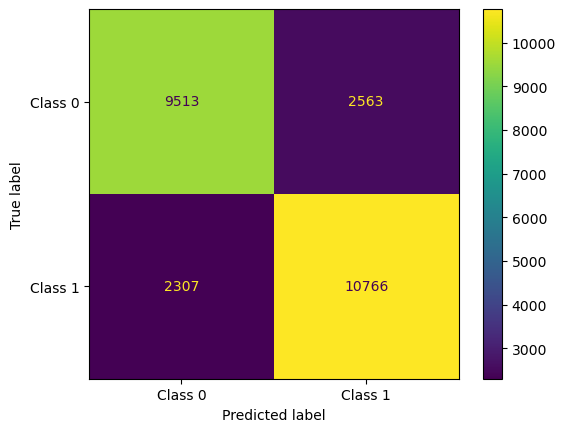

In [243]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

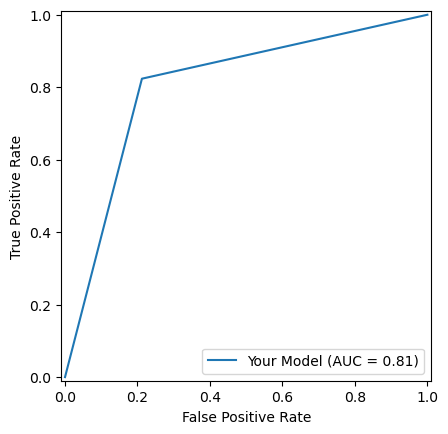

In [244]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Compute ROC curve and ROC area

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Your Model").plot()

In [245]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)

In [246]:
print(report)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     12076
           1       0.81      0.82      0.82     13073

    accuracy                           0.81     25149
   macro avg       0.81      0.81      0.81     25149
weighted avg       0.81      0.81      0.81     25149



In [247]:
from sklearn.model_selection import KFold, cross_val_score


In [248]:
def model_selector(model_name, model):
    output = []

    # Store model name
    output.append(model_name)

    # Create a pipeline with preprocessor and model
    pipeline = Pipeline([
        ('preprocessor', trf),  # Replace 'trf' with your preprocessing transformer
        ('model', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='accuracy')  # Adjust metric if needed
    output.append(scores.mean())  # Append mean accuracy score

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Append additional evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    output.append(accuracy)  # Append accuracy

    # Classification report (optional)
    report = classification_report(y_test, y_pred, output_dict=True)

    # You can extract additional details, e.g., F1-score or per-class accuracy
    output.append(report['weighted avg']['f1-score'])  # Weighted F1-score

    return output


In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

model_dict = {
    'logistic_reg': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier()
}


In [253]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(model_selector(model_name, model))

In [255]:
model_output

[['logistic_reg', 0.801313819642982, 0.8007475446339815, 0.8005810796132801],
 ['random_forest', 0.99655641022641, 0.9951886754940554, 0.9951886162707896],
 ['xgboost', 0.9420395950999902, 0.9441329675136189, 0.944111694134584]]

In [257]:
pipe2=Pipeline(
    steps=[
        ('step1',trf),
        ('step2',XGBClassifier())
    ]
)

In [259]:
pipe2.fit(x_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team',
                                                   'venue'])])),
                ('step2',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [261]:
y_pred=pipe2.predict(x_test)

In [263]:
accuracy_score(y_test,y_pred)

0.9442124935385104

In [265]:
report = classification_report(y_test,y_pred)

In [267]:
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12076
           1       0.95      0.95      0.95     13073

    accuracy                           0.94     25149
   macro avg       0.94      0.94      0.94     25149
weighted avg       0.94      0.94      0.94     25149



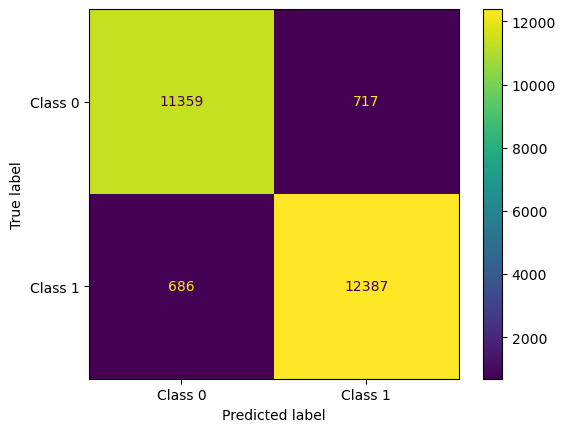

In [269]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [271]:
eval_row=pd.DataFrame({'batting_team':'Royal Challengers Bangalore',
          'bowling_team':'Mumbai Indians',
         'venue':'Wankhede Stadium',
          'runs_left':198,
          'ball_left':98,
          'wicket_left':10,
          'crr':17.63,
         'rrr':4.39
         },index=[0])

In [273]:
pipe2.predict(eval_row)

array([1])

In [275]:
pipe2.predict_proba(eval_row)

array([[0.16319871, 0.8368013 ]], dtype=float32)

In [277]:
import pickle
with open('pipeline2.pkl','wb') as file:
    pickle.dump(pipe2,file)


In [279]:
with open('ipl_predictor_dataset.pkl','wb') as file:
    pickle.dump(final_df,file)